<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Целью проекта является создание модели, которая будет предсказывать для каждого клиента вероятность совершения им покупки.

# Подготовка рабочей среды

In [1]:
!pip install -q --upgrade numpy
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade matplotlib
!pip install -q --upgrade numba
!pip install -q --upgrade seaborn
!pip install -q --upgrade pandas

!pip install phik

!pip install catboost
!pip install ipywidgets

!pip install lightgbm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.46.0 requires cloudpickle, which is not installed.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.2 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.46.0 requires cloudpickle, which is not installed.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.1.3 which is incompatible.


  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.46.0 requires cloudpickle, which is not installed.


In [2]:
!pip freeze > requirements.txt

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import os
import re
import datetime

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import ipywidgets
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import phik

from IPython.display import clear_output

In [4]:
# убрать предупреждения
import warnings
warnings.filterwarnings('ignore')

In [5]:
# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# необходимо для показа всех столбцов.
pd.options.display.max_columns = None

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Декларация функций и классов

In [7]:
def desdat(df):
    '''Describe dataframe'''
    print(df.info())
    print('*'*51)
    print(df.shape)
    print('*'*51)
    display(df.sample(5))

In [8]:
def num_eda(x, name):
    '''eda признаков с непрерывными значениями'''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    ax1.boxplot(x, vert=False)
    ax1.set(title=f'Boxplot {name}', xlabel='values', ylabel='item')
    
    ax2.hist(x, bins=20, rwidth=0.7)
    ax2.set(title=f'Гистрограмма  {name}', xlabel='values', ylabel='count entries')
    
    clear_output()
    plt.show()
    

    
def dis_eda(data, name):
    '''eda признаков с дискретным значением'''
    ind = data.value_counts().index.to_list()
    height = data.value_counts().to_list()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.bar(ind, height)
    ax.set_xticks(range(min(ind), max(ind)+1))
    ax.set(title=f'Bar plot {name}', xlabel='values', ylabel='count_entries')
    
    clear_output()
    plt.show()
    

In [9]:
# агрегирющие функции для создания новых признаков

def mpc(x):
    '''самая популярная категория товара для client_id'''
    m = []
    for i in x.tolist():
        for j in  re.findall(r'[0-9]+', i):
            m.append(j)
    try:
        return pd.Series(m).mode()[0]
    except:
        # отсутствие значений в pd.series() означает отсутствие категорий в датасете.
        return '-1'

    
def var_date_ord(x):
    '''вычисление дисперсии/кучности/частоты заказов пользователя'''
    return np.var(np.array([datetime.datetime.strptime(_, '%Y-%m-%d').timestamp()//(24*60*60) for _ in x]))


def loyality(x):
    '''создание лояльности пользователя на основе его действий с рекламными рассылками'''
    ag = x.value_counts()
    ind = ag.index.to_list()
    loyality = 0
    for i in ind:
        if i == 'send':
            loyality += ag[i] * 0
        elif i == 'click':
            loyality += ag[i] * 1
        elif i == 'open':
            loyality += ag[i] * 2
        elif i == 'subscribe':
            loyality += ag[i] * 3
        elif i == 'close':
            loyality += ag[i] * -1
        elif i == 'soft_bounce':
            loyality += ag[i] * -2
        elif i == 'hard_bounce':
            loyality += ag[i] * -3
        elif i == 'unsubscribe':
            loyality += ag[i] * -4
        elif i == 'hbq_spam':
            loyality += ag[i] * -5
        elif i == 'complain':
            loyality += ag[i] * -6
    return loyality




# Загрузка и ознакомление с данными

**apparel-purchases** - *ap*

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- **client_id** идентификатор клиента
- **quantity** количество единиц товара
- **price** цена товара
- **category_ids** идентификаторы категорий
- **date** дата покупки
- **message_id** идентификатор сообщения из рассылки

---

**apparel-messages** - *am*

Рассылки, которые были отправлены клиентам из таблицы покупок.

- **bulk_campaign_id** идентификатор рассылки
- **client_id** идентификатор клиента
- **message_id** идентификатор сообщения
- **event** действие с сообщением (отправлено, открыто, покупка...)
- **channel** канал рассылки
- **date** дата действия
- **created_at** дата-время полностью

---

**target** - *atb*

- **client_id** идентификатор клиента
- **target** клиент совершил покупку в целевом периоде

---

**full_campaign_daily_event** - *fcde*

- **date** дата
- **bulk_campaign_id** идентификатор рассылки
- **count_event*** общее количество каждого события event
- **nunique_event*** количество уникальных client_id в каждом событии

---

**full_campaign_daily_event_channel** - *fcdec*

- **date** дата
- **bulk_campaign_id** идентификатор рассылки
- **count_event\*_channel\*** общее количество каждого события по каналам
- **nunique_event\*_channel\*** количество уникальных client_id по событиям и каналам

---

In [10]:
condition = os.path.exists('apparel-messages.csv') and\
            os.path.exists('apparel-purchases.csv') and\
            os.path.exists('apparel-target_binary.csv') and\
            os.path.exists('full_campaign_daily_event.csv') and\
            os.path.exists('full_campaign_daily_event_channel.csv')
if condition:
    ap = pd.read_csv('apparel-purchases.csv') # история покупок
    am = pd.read_csv('apparel-messages.csv') # история рекламных рассылок
    atb = pd.read_csv('apparel-target_binary.csv') # покупка в течение 90 дней
    fcde = pd.read_csv('full_campaign_daily_event.csv') # агрегация базы рассылок по дням и типам событий
    fcdec = pd.read_csv('full_campaign_daily_event_channel.csv') # агрегация по дням с учетом событий и каналов рассылки
else:
    raise FileNotFoundError('something do wrong')

In [11]:
desdat(ap)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None
***************************************************
(202208, 6)
***************************************************


,client_id,quantity,price,category_ids,date,message_id
33200,1515915625489183282,1,999.00,"['4', '28', '260', '420']",2022-08-23,1515915625488651976-5922-62ff35646a3ae
78078,1515915625566612906,1,"5,999.00","['4', '28', '62', '657']",2022-12-24,1515915625566612906-8995-63a5b12f6f611
13217,1515915625590623396,1,399.00,"['4', '28', '124', '415']",2022-06-13,1515915625489241457-4744-629b3ff8de418
15680,1515915625468104130,1,799.00,"['4', '28', '57', '431']",2022-06-22,1515915625468104130-5052-62b2c1a08dd55
10947,1515915625566827287,1,"1,699.00","['4', '28', '275', '421']",2022-06-04,1515915625566827287-4744-629b4021316ab


In [12]:
desdat(am)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None
***************************************************
(12739798, 7)
***************************************************


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
11718403,14502,1515915625468142036,1515915625468142036-14502-65aa367f459ae,send,email,2024-01-19,2024-01-19 11:02:24
2720924,8082,1515915625629302084,1515915625629302084-8082-637e2779378c9,send,mobile_push,2022-11-25,2022-11-25 06:58:43
10201526,14272,1515915625491475973,1515915625491475973-14272-6575a8ecf315c,open,mobile_push,2023-12-10,2023-12-10 14:12:49
9721017,14195,1515915625791982678,1515915625791982678-14195-656479a65cb7d,send,email,2023-11-27,2023-11-27 13:29:41
2412631,7810,1515915625551936138,1515915625551936138-7810-636e58fa36a11,send,mobile_push,2022-11-11,2022-11-11 14:31:15


In [13]:
desdat(atb)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None
***************************************************
(49849, 2)
***************************************************


,client_id,target
38198,1515915625646023922,0
22049,1515915625517092139,0
6807,1515915625487789944,0
5129,1515915625481242320,0
34632,1515915625590543932,0


In [14]:
desdat(fcde)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
111892,2024-02-26,14524,3,0,0,216,0,0,0,0,16,2,0,0,214,0,0,0,0,16,0,0,0,0
61210,2023-03-08,4832,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
114404,2024-03-08,14109,0,0,0,13,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0
37132,2022-11-24,4935,0,0,0,2,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,0
15872,2022-08-17,4832,0,0,0,8,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0


In [15]:
desdat(fcdec)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
28225,2022-10-16,4591,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41950,2022-12-14,3131,0,0,20,0,0,0,0,0,2,0,0,20,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
91434,2023-11-05,13974,3,0,335,0,0,0,0,0,1,2,0,331,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128628,2024-05-05,14087,1,0,34,0,0,0,0,0,3,1,0,34,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104534,2024-01-23,14514,0,53,0,11,0,3,0,0,0,0,41,0,11,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Предобработка данных

In [16]:
ap.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [17]:
# в данном датасете дубликаты не являются ошибкой базы данных.
# клиент мог повторить заказ в этот же день, поэтому появляются одинаковые записи.
ap.duplicated().sum()

73020

---

In [18]:
am.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [19]:
# аналогично ap.
am.duplicated().sum()

48610

---

In [20]:
atb.isna().sum()

client_id    0
target       0
dtype: int64

In [21]:
atb.duplicated().sum()

0

In [22]:
# в данной таблице client_id - первичный ключ.
atb['client_id'].nunique()

49849

---

In [23]:
fcde.isna().sum()

date                   0
bulk_campaign_id       0
count_click            0
count_complain         0
count_hard_bounce      0
count_open             0
count_purchase         0
count_send             0
count_soft_bounce      0
count_subscribe        0
count_unsubscribe      0
nunique_click          0
nunique_complain       0
nunique_hard_bounce    0
nunique_open           0
nunique_purchase       0
nunique_send           0
nunique_soft_bounce    0
nunique_subscribe      0
nunique_unsubscribe    0
count_hbq_spam         0
nunique_hbq_spam       0
count_close            0
nunique_close          0
dtype: int64

In [24]:
fcde.duplicated().sum()

0

---

In [25]:
fcdec.isna().sum()

date                               0
bulk_campaign_id                   0
count_click_email                  0
count_click_mobile_push            0
count_open_email                   0
count_open_mobile_push             0
count_purchase_email               0
count_purchase_mobile_push         0
count_soft_bounce_email            0
count_subscribe_email              0
count_unsubscribe_email            0
nunique_click_email                0
nunique_click_mobile_push          0
nunique_open_email                 0
nunique_open_mobile_push           0
nunique_purchase_email             0
nunique_purchase_mobile_push       0
nunique_soft_bounce_email          0
nunique_subscribe_email            0
nunique_unsubscribe_email          0
count_hard_bounce_mobile_push      0
count_send_mobile_push             0
nunique_hard_bounce_mobile_push    0
nunique_send_mobile_push           0
count_hard_bounce_email            0
count_hbq_spam_email               0
count_send_email                   0
n

In [26]:
fcdec.duplicated().sum()

0

**Итоги раздела**

Все данные чисты и не содержат ошибочных дубликатов.

# Создание рабочего датасета

In [27]:
df = pd.DataFrame()

In [28]:
df['client_id'] = atb['client_id']

In [29]:
# добваление столбца с общим количеством покупок
df = df.merge(ap.groupby(['client_id'])['quantity'].sum().reset_index().rename({'client_id':'client_id', 'quantity':'count_items'}, axis=1), on='client_id')
df['count_items'] = df['count_items'].astype('int')

In [30]:
# добваление столбца с количеством заказов
df = df.merge(ap.groupby(['client_id'])['quantity'].count().reset_index().rename({'client_id':'client_id', 'quantity':'count_orders'}, axis=1), on='client_id')
df['count_items'] = df['count_items'].astype('int')

In [31]:
# добавление самой популярной категории
df = df.merge(ap.groupby('client_id')['category_ids'].agg(mpc).reset_index().rename({'client_id':'client_id', 'category_ids':'main_cat_id'}, axis=1), on='client_id')
df['main_cat_id'] = df['main_cat_id'].astype('object')

In [32]:
# добавление общей суммы заказов
df = df.merge(ap.groupby('client_id')['price'].sum().reset_index().rename({'client_id':'client_id', 'price':'total_sum'}, axis=1), on='client_id')

In [33]:
# Добавление диспресии даты заказа (в днях)
df = df.merge(ap.groupby('client_id')['date'].agg(var_date_ord).reset_index().rename({'client_id':'client_id', 'date':'var_ord'}, axis=1), on='client_id')

In [34]:
# добавление количества уникальных рекламных сообщений при заказах
df = df.merge(ap.groupby('client_id')['message_id'].agg(lambda x: x.nunique()).reset_index().rename({'client_id':'client_id', 'message_id':'num_uniq_mid'}, axis=1), on='client_id')

In [35]:
# добавление основного источника получения рекламмных рассылок
df = df.merge(am.groupby('client_id')['channel'].agg(lambda x: x.mode()[0]).reset_index().rename({'client_id':'client_id', 'channel':'main_channel'}, axis=1), on='client_id')

In [36]:
# добавление лояльности пользователя к рекламным сообщениям
df= df.merge(am.groupby('client_id')['event'].agg(loyality).reset_index().rename({'client_id':'client_id', 'event':'loyality'}, axis=1), on='client_id')

In [37]:
df = df.merge(atb, on='client_id')

In [38]:
df.head()

,client_id,count_items,count_orders,main_cat_id,total_sum,var_ord,num_uniq_mid,main_channel,loyality,target
0,1515915625468060902,7,7,4,"6,993.00",0.00,1,email,76,0
1,1515915625468061003,7,7,249,"16,235.00",0.00,1,email,16,1
2,1515915625468061099,1,1,28,299.00,0.00,1,email,104,0
3,1515915625468061100,2,2,1828,"2,098.00",0.00,1,mobile_push,322,0
4,1515915625468061170,19,19,28,"33,601.00",868.42,3,email,78,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   client_id     41982 non-null  int64  
 1   count_items   41982 non-null  int32  
 2   count_orders  41982 non-null  int64  
 3   main_cat_id   41982 non-null  object 
 4   total_sum     41982 non-null  float64
 5   var_ord       41982 non-null  float64
 6   num_uniq_mid  41982 non-null  int64  
 7   main_channel  41982 non-null  object 
 8   loyality      41982 non-null  int64  
 9   target        41982 non-null  int64  
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 3.0+ MB


---

In [40]:
df.isna().sum()

client_id       0
count_items     0
count_orders    0
main_cat_id     0
total_sum       0
var_ord         0
num_uniq_mid    0
main_channel    0
loyality        0
target          0
dtype: int64

In [41]:
df.duplicated().sum()

0

**Итоги этапа**

В данном разделе на основе входных таблиц был построен рабочий датастет с необходимыми признаками. Он не содержит пропусков и дубликатов.

Описание признаков рабочего датасета

| признак | описание |
|--- | --- |
| client_id |  идентификатор пользователя |
| count_items |  общее количество товаров пользователя |
| count_orders |  количество заказов пользователя |
| total_sum |  общая сумма заказов |
| var_ord |  дисперсия времени заказов, частота/кучность заказов
| num_uniq_mid |  количество уникальных message_id для пользователя |
| loyality |  лояльность пользователя к сервису, основанная на реакциях с рассылок |
| target |  целевой признак |

# Исследовательский ананлиз данных

In [42]:
df.describe()

,client_id,count_items,count_orders,total_sum,var_ord,num_uniq_mid,loyality,target
count,"41,982.00","41,982.00","41,982.00","41,982.00","41,982.00","41,982.00","41,982.00","41,982.00"
mean,"1,515,915,625,590,884,352.00",3.99,3.96,"4,767.60","1,249.36",1.18,128.39,0.02
std,"148,746,690.08",5.34,5.30,"7,295.45","5,918.22",0.58,153.02,0.14
min,"1,515,915,625,468,060,928.00",1.00,1.00,1.00,0.00,1.00,-470.00,0.00
25%,"1,515,915,625,489,307,648.00",1.00,1.00,"1,499.00",0.00,1.00,14.00,0.00
50%,"1,515,915,625,520,578,048.00",2.00,2.00,"2,808.00",0.00,1.00,62.00,0.00
75%,"1,515,915,625,629,339,648.00",4.00,4.00,"5,598.00",0.00,1.00,201.00,0.00
max,"1,515,915,626,010,261,248.00",218.00,218.00,"540,408.00","89,401.00",17.00,"2,737.00",1.00


In [43]:
df.describe(include='object')

,main_cat_id,main_channel
count,41982,41982
unique,386,2
top,28,mobile_push
freq,10140,22736


In [44]:
# этим кодом мы убрали из датасета два выброса из count_itmes, которые и так не повлияют на общую картину, т.к. target у них равен 0.
df = df[df['count_items'] < 200]

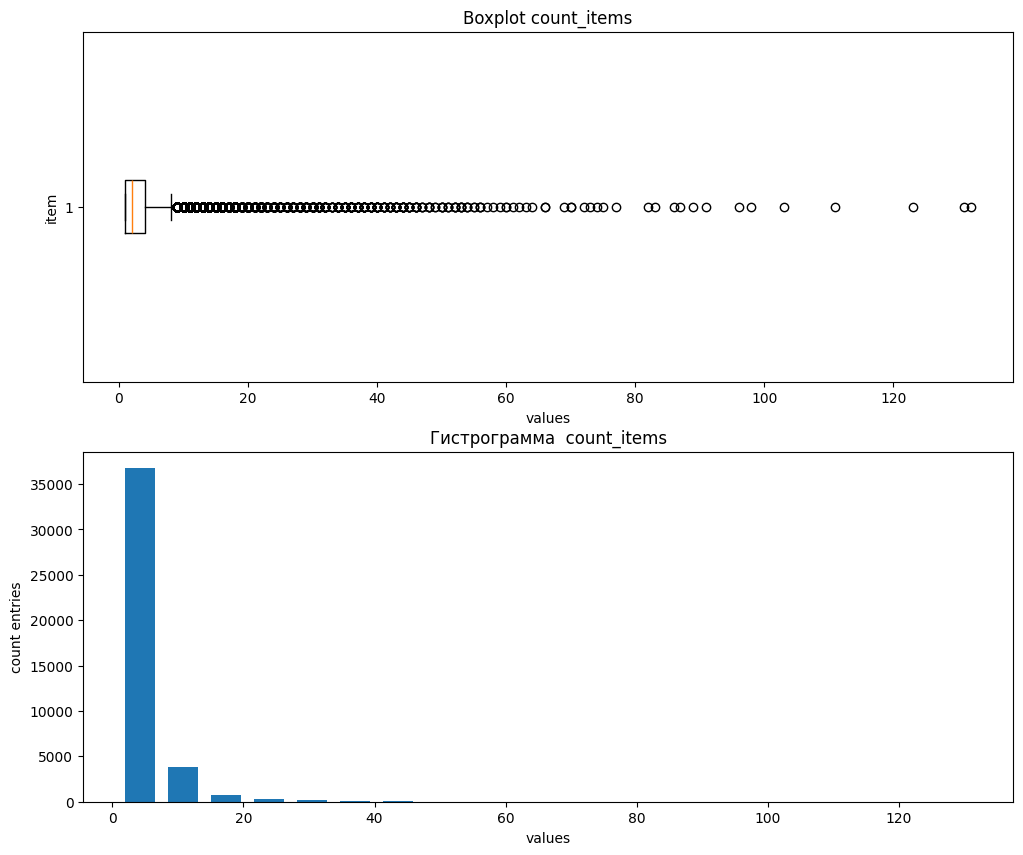

In [45]:
num_eda(df['count_items'], 'count_items')

Видно, что количество товаров пользователей, в общей степени достаточно мало. Много единиц товара заказали всего пара десятков пользователей.

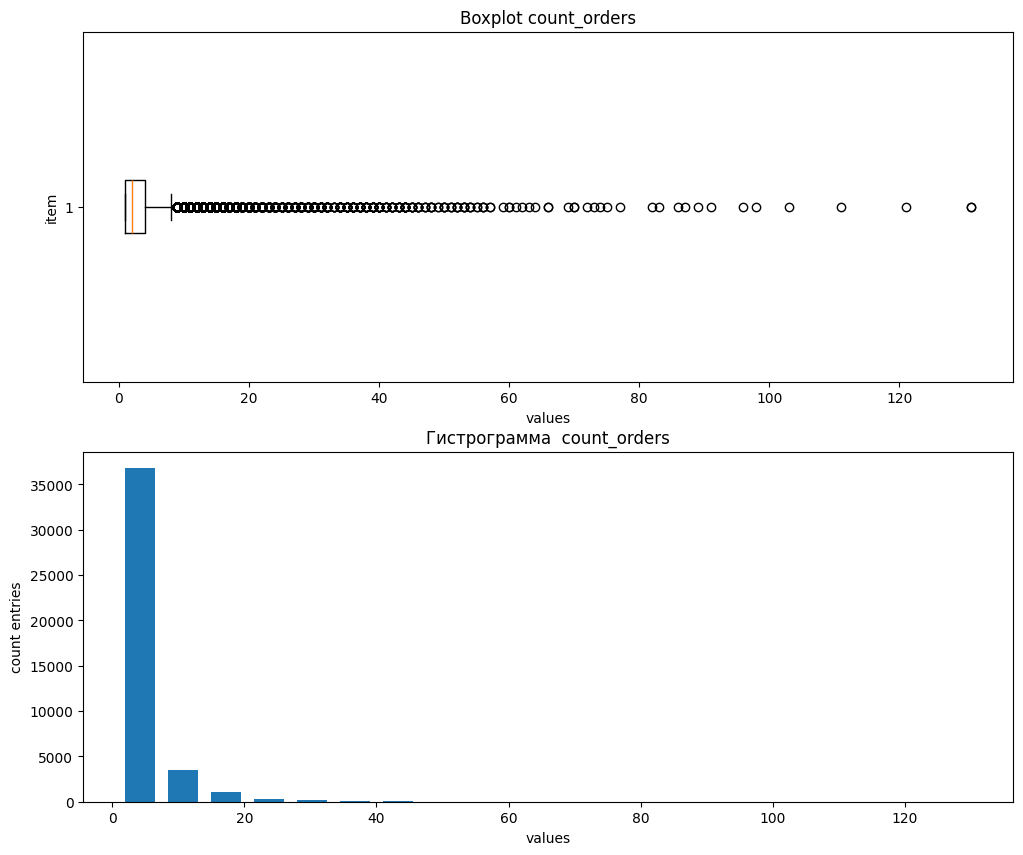

In [46]:
num_eda(df['count_orders'], 'count_orders')

Количество заказов также, как и количество заказанного товара, в общей степени мало.

In [47]:
# удалим из датасета выбросы по total_sum. Они в target имеют 0, поэтому мы ничего не теряем.
df = df[df['total_sum'] < 200000]

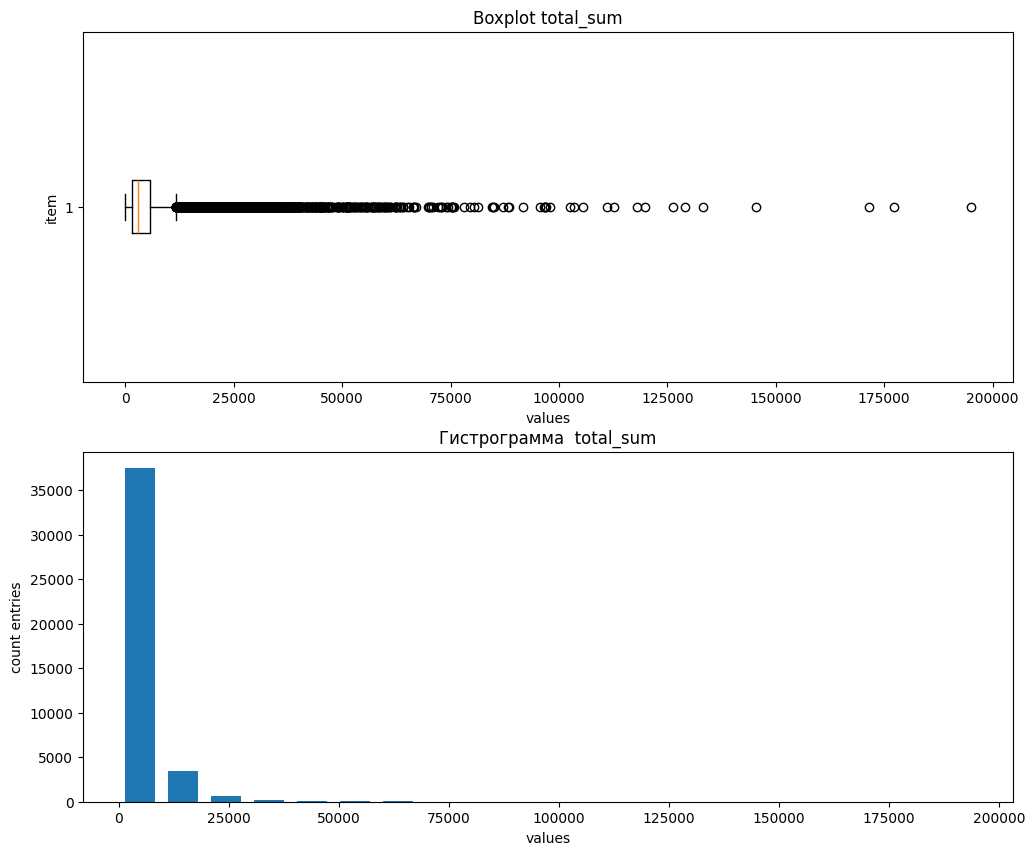

In [48]:
num_eda(df['total_sum'], 'total_sum')

График общей суммы пользователей не вызывает удивления. Из общей массы пользователей сервиса выделяется небольшое количество с большими показателями.

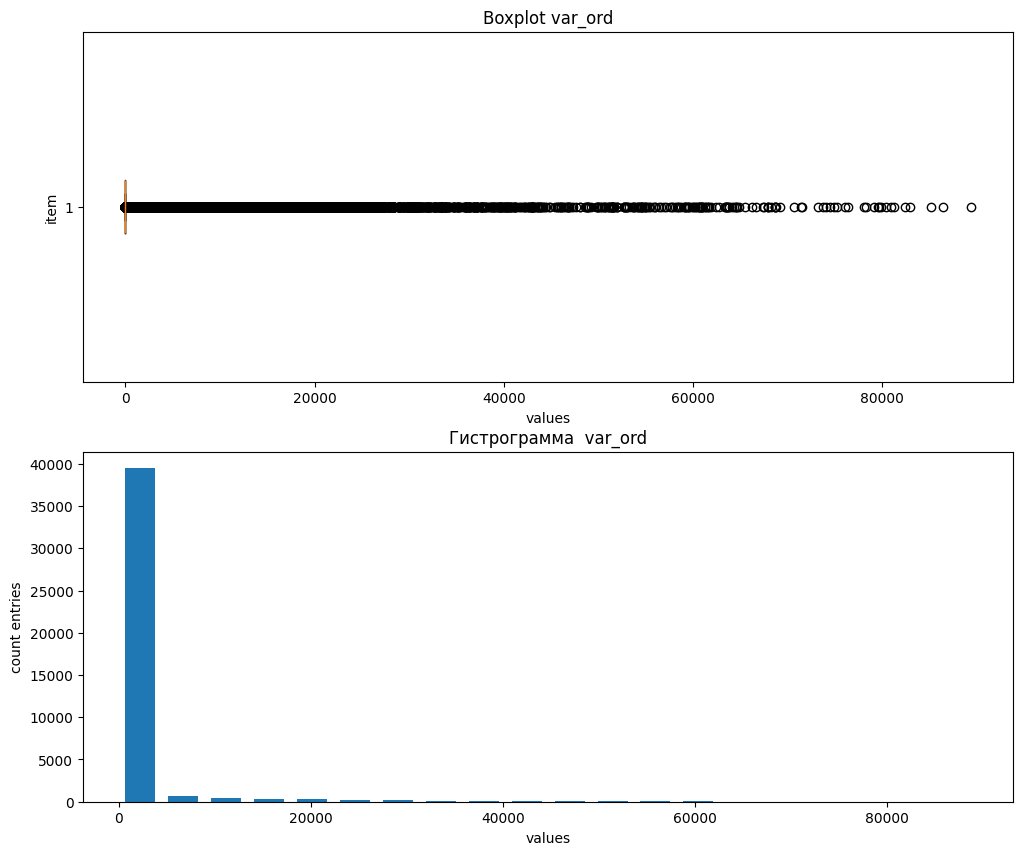

In [49]:
num_eda(df['var_ord'], 'var_ord')

График частотности заказов выглядит странно. Такое распределение может говорить о молодости интернет магазина. Большая часть пользователей совершила все заказы в достаточно короткий срок.

---

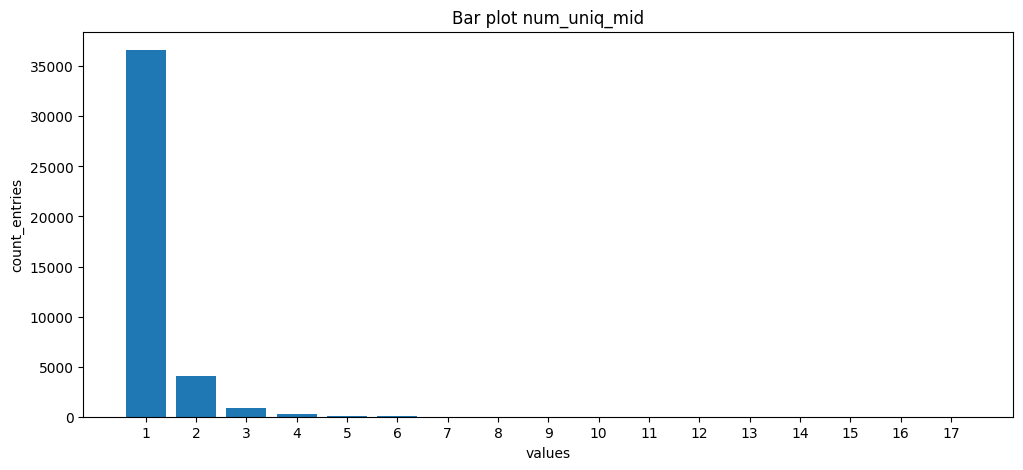

In [50]:
dis_eda(df['num_uniq_mid'], 'num_uniq_mid')

Данный график показывает, что большая часть заказов была соверешена пользователями, исходя из одного-двух рекламных собщений.

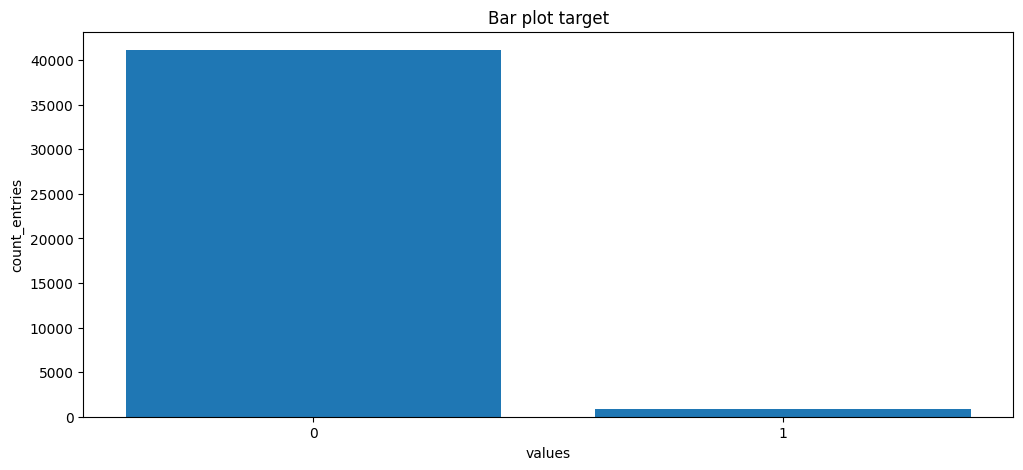

In [51]:
dis_eda(df['target'], 'target')

Здесь распределение целевого признака. Отличие в десятки, если не в сотни, раз. Датасет очень не сбалансирован.

---

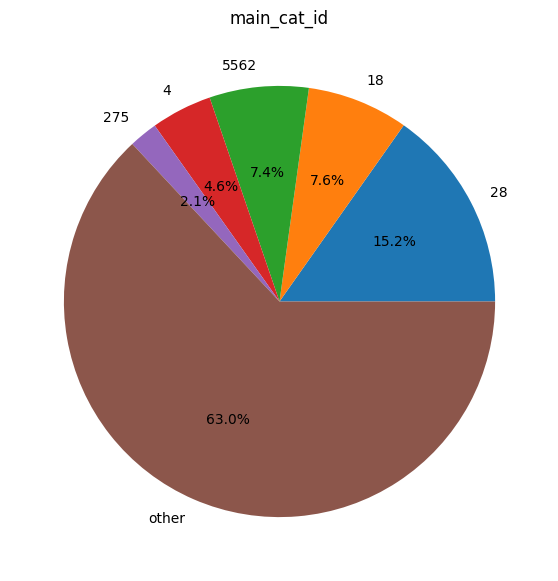

In [52]:
fig, ax = plt.subplots(figsize=(7,7))

x = df['main_cat_id'].value_counts().head(5)
x['other'] = df['main_cat_id'].value_counts().head(-5).sum()

ax.pie(x, labels=x.index,  autopct='%1.1f%%')
ax.set(title='main_cat_id')

clear_output()
plt.show()

Самая популярная заказываемая категория товара - это 28, 18 и 5562.

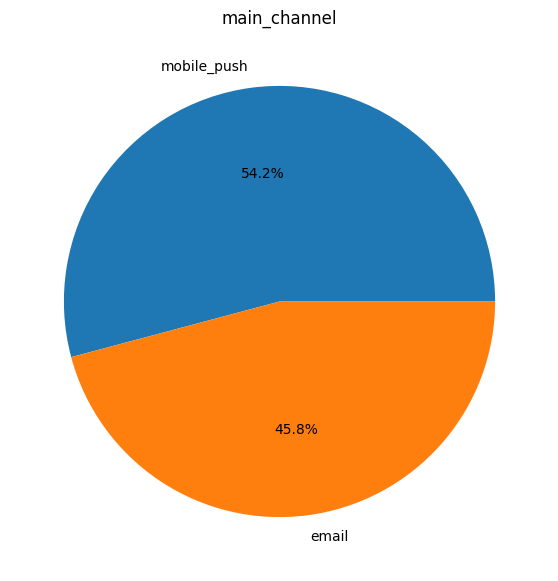

In [53]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df['main_channel'].value_counts()

ax.pie(x, labels=x.index,  autopct='%1.1f%%')
ax.set(title='main_channel')

clear_output()
plt.show()

Канал рассылок распределился равномерно между почтой и мобильными уведомлениями.

**Итоги этапа**

Исследовательский анализ данных проведён. В датасете сильный дисбаланс. Очень много значений 0 в целевом признаке. Очень много клиентов с маленьким количеством заказов и соответсвующими характеристиками. Но есть также небольшое количество выбивающихся из общей массы значений.

# Корреляционный анализ 

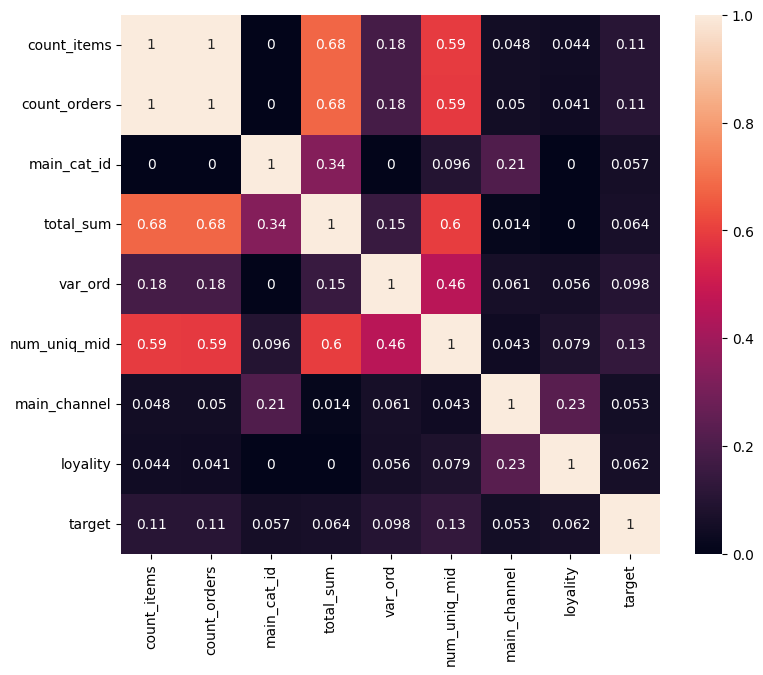

In [54]:
_ = df.drop(['client_id'], axis=1).phik_matrix(interval_cols=['count_items', 'count_orders', 'total_sum', 'var_ord', 'loyality'])

fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(_, annot=True, ax=ax, square=True)

clear_output()
plt.show()

**Итоги этапа**

На данном этапе корреляционный анализ показал, что признаки не мультиколлинеарны и не содержат сильных корреляций.

# Разработка модели машинного обучения

**подготовка данных**

In [55]:
y = df['target']
x = df.drop(['client_id', 'target'], axis=1)

In [56]:
random_state = 1337

In [57]:
target = 'target'
num_cols = ['count_items', 'count_orders', 'total_sum', 'var_ord', 'num_uniq_mid', 'loyality']
cat_cols = ['main_cat_id', 'main_channel']

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=random_state)

In [59]:
categories = [x['main_cat_id'].unique().tolist(), x['main_channel'].unique().tolist()]

In [60]:
encoder = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=categories, 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)



data_preprocessor = ColumnTransformer(
    [
        ('cat', encoder, cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [61]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LGBMClassifier(random_state=random_state))
    ]
)

---

**Обучение**

In [62]:
param_grid = [
    {
        'model': [LogisticRegression(random_state=random_state)],
        'model__C' : np.logspace(-4,4),
        'model__max_iter'  : [100,1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [DecisionTreeClassifier(random_state=random_state)],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors' : [5,7],
        'model__weights' : ['uniform','distance'],
        'model__metric' : ['euclidean','manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [SVC(random_state=random_state)],
        'model__C': [0.1, 1],  
        'model__gamma': [1, 0.1, 0.0001], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC', random_state=random_state)],
        'model__iterations': range(5, 16, 5),
        'model__learning_rate': [0.03, 0.1],
        'model__depth': [4, 6, 10],
        'model__l2_leaf_reg': [1, 3, 7, 9],
        'preprocessor__cat': ['passthrough'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [LGBMClassifier(random_state=random_state, )],
        'model__num_leaves': [2, 5, 20, 30],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__n_estimators': [50, 100, 150, 200],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
]

In [63]:
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    n_iter=10
)

In [64]:
%%time
start = time()
rs.fit(x_train, y_train)
end = time()
clear_output()
print(end-start)

7.060590982437134
CPU times: total: 2.08 s
Wall time: 7.06 s


In [65]:
rs.best_score_

0.7034628995674994

In [66]:
rs.best_params_

{'preprocessor__num': StandardScaler(),
 'model__num_leaves': 5,
 'model__n_estimators': 100,
 'model__learning_rate': 0.05,
 'model': LGBMClassifier(random_state=1337)}

In [67]:
rs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['4',
                                                                                               '249',
                                                                                               '28',
                                                                                               '1828',
                                                                                               '239',
                                                                                               '1829',
                                                                                               '1848',
                                                                                               '6060',
                                                                                               '1325',
                                                                                               '5549',
                                                                                               '18',
                                                                                               '213',
                                                                                               '31',
                                                                                               '244',
                                                                                               '275',
                                                                                               '5562',
                                                                                               '555',
                                                                                               '146',
                                                                                               '1329',
                                                                                               '6058',
                                                                                               '1570',
                                                                                               '17'...
                                                                                               'mobile_push']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['main_cat_id',
                                                   'main_channel']),
                                                 ('num', StandardScaler(),
                                                  ['count_items',
                                                   'count_orders', 'total_sum',
                                                   'var_ord', 'num_uniq_mid',
                                                   'loyality'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, num_leaves=5,
                                random_state=1337))])

---

In [68]:
lgbm_param_grid = {
    'model': [LGBMClassifier(random_state=random_state)],
    'model__num_leaves': [2, 5, 20],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [50, 100, 150],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}

In [69]:
gs = GridSearchCV(
    pipe_final,
    lgbm_param_grid,
    scoring='roc_auc',
    cv=5
)

In [70]:
%%time
start = time()

gs.fit(x_train, y_train)
clear_output()

end= time()
clear_output()

print(end-start)

92.16529440879822
CPU times: total: 5min 10s
Wall time: 1min 32s


In [71]:
gs.best_score_

0.7034628995674994

In [72]:
gs.best_params_

{'model': LGBMClassifier(random_state=1337),
 'model__learning_rate': 0.05,
 'model__n_estimators': 100,
 'model__num_leaves': 5,
 'preprocessor__num': StandardScaler()}

In [73]:
gs.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['4',
                                                                                               '249',
                                                                                               '28',
                                                                                               '1828',
                                                                                               '239',
                                                                                               '1829',
                                                                                               '1848',
                                                                                               '6060',
                                                                                               '1325',
                                                                                               '5549',
                                                                                               '18',
                                                                                               '213',
                                                                                               '31',
                                                                                               '244',
                                                                                               '275',
                                                                                               '5562',
                                                                                               '555',
                                                                                               '146',
                                                                                               '1329',
                                                                                               '6058',
                                                                                               '1570',
                                                                                               '17'...
                                                                                               'mobile_push']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['main_cat_id',
                                                   'main_channel']),
                                                 ('num', StandardScaler(),
                                                  ['count_items',
                                                   'count_orders', 'total_sum',
                                                   'var_ord', 'num_uniq_mid',
                                                   'loyality'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.05, num_leaves=5,
                                random_state=1337))])

---
**Тестирование**

In [74]:
model = LGBMClassifier(learning_rate=0.05, num_leaves=5, random_state=1337, n_estimators=100)

In [75]:
x_train_prep = data_preprocessor.fit_transform(x_train)
x_test_prep = data_preprocessor.transform(x_test)

In [76]:
%%time
start = time()

model.fit(x_train_prep, y_train)

end = time()

clear_output()

print(end-start)

0.09675049781799316
CPU times: total: 188 ms
Wall time: 101 ms


In [77]:
roc_auc_score(y_test, model.predict_proba(x_test_prep)[:,1])

0.7277311518002786

**Итоги этапа**

Среди обучаемых моделей были простые алгоритмы, такие как логистическая регрессия, метод k ближайших соседей и другие, и градиентный бустинг. Модель LGBMClassifier стала лучшей. Её показатель roc_auc_score на тестовых данных выше 0.7.  

# Анализ важности признаков 

In [78]:
labels = data_preprocessor.get_feature_names_out().tolist()
values = model.feature_importances_.tolist()

In [79]:
d = {l: v for (l, v) in zip(labels, values)}

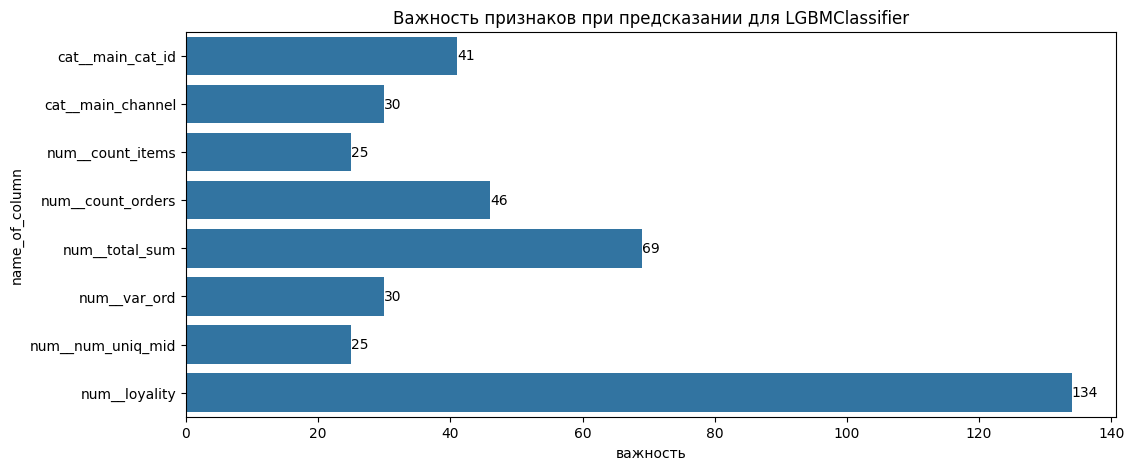

In [80]:
fig, ax = plt.subplots(figsize=(12, 5))

pl = sns.barplot(d, orient='h')

ax.bar_label(pl.containers[0], labels=d.values(), label_type='edge')

ax.set(title='Важность признаков при предсказании для LGBMClassifier', ylabel='name_of_column', xlabel='важность')

clear_output()

plt.show()

**Вывод по этапу**

В данном разделе была определена важность признаков для модели. Это даст понять заказчику, на что стоит обращать внимание при взаимодействии с клиентом.

Наибольшее значение, определяющее статус пользователя, имеет лояльность пользователся к информационным рассылкам (показатель основан на действиях пользователя исходя из получения рекламного сообщения), общая сумма заказов пользователя и общее количество заказов пользователя.

# Вывод по проекту

В ходе данного проетка была достигнута цель и выполнены все задачи.

- Полученные данные от заказчика были изучены и проанализированны;
- На основе сырых данных был составлен рабочий датасет с полезными признаками, кот. имеют значимость для данного проекта;
- Были рассомтренны различные модели машинного обучения и из них выбрана лучшая;
- Итоговая метрика roc_auc_score на тестовых данных имеет значение выше 0.72;
- Проведено тестирование модели;
- Проведён анализ важности признаков, кот. показал значимость признаков на ключевой показатель.


Данные показывают, что большая часть пользователей из истории не совершала покупку в течение 90 дней. Поэтому данные достаточно имбалансны. Признаки в рабочем датасете не имеют взаимных корреляций, что говорит о качетсве разработанного набора признаков. Итоговая модель использует градиентный бустинг для обучения, поэтому обучается достаточно быстро. Целевая метрика на тестовой выборке данных превышает 0.72. Наиболее важными признаками при классификации оказались лояльность пользователя к сервису, количество заказов пользователя и общая сумма заказов.